In [ ]:
#Importa bibliotecas principais para manipulação de dados e ML
import numpy as np
import pandas as pd

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate, GridSearchCV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)


In [ ]:
# Carrega a base de clientes (com histórico de cancelamento)
df = pd.read_csv("clientes_churn.csv")
print(df.head())


   ClienteID  Idade  MesesComoCliente    Plano  QtdCompras  Satisfacao  Churn
0          1     39                14  Premium           9           5      1
1          2     55                38   Padrão          43           4      0
2          3     64                59   Padrão          34           4      0
3          4     56                49   Padrão          29           1      0
4          5     52                 7   Básico          29           4      1


In [ ]:
# Converte a coluna 'Plano' em variáveis dummies (one-hot encoding)
df = pd.get_dummies(df, columns=['Plano'], drop_first=True)


In [14]:
X = df.drop(columns=['ClienteID','Churn'])  
y = df['Churn']


In [ ]:
# Separa em treino e teste (80/20) e aplica estratificação no target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, f1_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier

# Cria modelo de Random Forest com hiperparâmetros ajustados
modelo = RandomForestClassifier(
    n_estimators=400,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=3,
    max_features='log2',
    class_weight='balanced',
    random_state=42
)

# Treina e salva o modelo
modelo.fit(X_train, y_train)

import joblib
joblib.dump(modelo, 'modelo_churn.pkl')

['modelo_churn.pkl']

In [ ]:
y_pred = modelo.predict(X_test)
y_prob = modelo.predict_proba(X_test)[:, 1]
y_pred_custom = (y_prob >= 0.4).astype(int)

print("=== Threshold padrão (0.5) ===")
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("=== Threshold customizado (0.4) ===")
print("Acurácia:", accuracy_score(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

# Testar vários thresholds de uma vez
from sklearn.metrics import classification_report

# Testa modelo em diferentes thresholds (0.3, 0.4, 0.5, 0.6)
# para ver o impacto em precisão, recall e F1-score
thresholds = [0.3, 0.4, 0.5, 0.6]

# lista pra guardar os resultados
results = []

for t in thresholds:
    y_pred_custom = (y_prob >= t).astype(int)
    
    # pega o relatório como dicionário
    report = classification_report(y_test, y_pred_custom, output_dict=True)
    
    # pega só a classe 1 (os canceladores)
    precision = report["1"]["precision"]
    recall    = report["1"]["recall"]
    f1        = report["1"]["f1-score"]
    
    results.append({
        "Threshold": t,
        "Precision (classe 1)": precision,
        "Recall (classe 1)": recall,
        "F1-score (classe 1)": f1
    })
df_results = pd.DataFrame(results)
print(df_results)

# Testa modelo em diferentes thresholds (0.3, 0.4, 0.5, 0.6)
# para ver o impacto em precisão, recall e F1-score

=== Threshold padrão (0.5) ===
Acurácia: 0.575
              precision    recall  f1-score   support

           0       0.67      0.64      0.65        25
           1       0.44      0.47      0.45        15

    accuracy                           0.57        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.58      0.57      0.58        40

=== Threshold customizado (0.4) ===
Acurácia: 0.55
              precision    recall  f1-score   support

           0       0.82      0.36      0.50        25
           1       0.45      0.87      0.59        15

    accuracy                           0.55        40
   macro avg       0.63      0.61      0.55        40
weighted avg       0.68      0.55      0.53        40

   Threshold  Precision (classe 1)  Recall (classe 1)  F1-score (classe 1)
0        0.3              0.361111           0.866667             0.509804
1        0.4              0.448276           0.866667             0.590909
2        0.5           

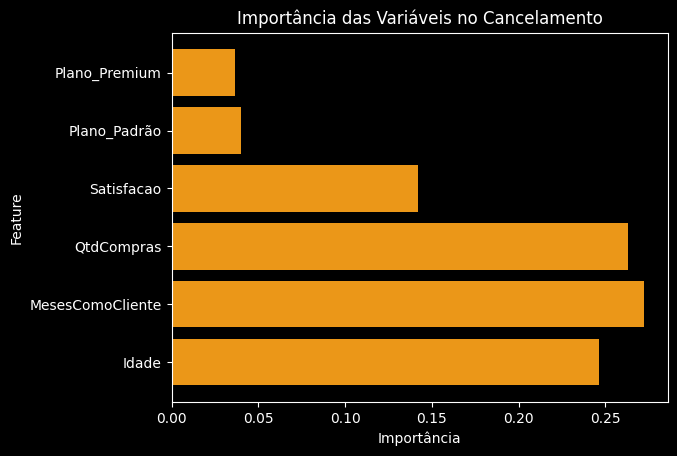

In [23]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

importances = modelo.feature_importances_
features = X.columns

plt.barh(features, importances, color="#eb9718")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.title("Importância das Variáveis no Cancelamento")
plt.show()
